In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import argparse
import glob
import pickle
from collections import OrderedDict
import math
%matplotlib inline

from matplotlib import rc
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams.update({'axes.titlesize':20, 'axes.labelsize':20, 'legend.fontsize':18, 'xtick.labelsize':14,
                     'ytick.labelsize':14, 'figure.figsize':(8.4,3.36), 'lines.linewidth':0.8})

#"figure.figsize":(4.2, 3.36)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

directories = ['src/output/xsyn', 'src/output/zsyn']

def get_log_ticks(skip=1, num=5, base=10, axes='y'):
    if axes == 'y':
        locs, ylabels = plt.yticks()
    else:
        locs,ylabels = plt.xticks()
    minor_locs = []
    tick_labels = []
    for val in locs[:-1]:
        val_ticks = np.linspace(base**val, base**(val+skip), num)
        tick_labels.append('$10^{'+str(int(val))+'}$')

        for _ in val_ticks[:-2]:
            tick_labels.append('')

        for val_tick in val_ticks[:-1]:
            minor_locs.append(math.log(val_tick, base))
    minor_locs.append(locs[-1])
    tick_labels.append('$'+str(int(base))+'^{'+str(int(locs[-1]))+'}$')
    return (minor_locs, tick_labels)


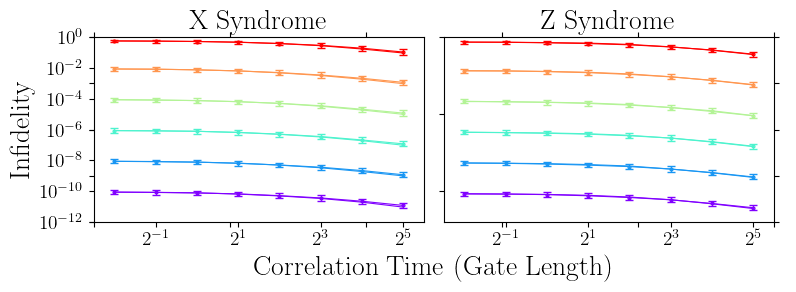

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, )
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)


for fig_num, directory in enumerate(directories):
    if fig_num == 0:
        ax = ax1
    else:
        ax = ax2
    
    if 'xsyn' in directory:
        title = "X Syndrome"
    else:
        title = "Z Syndrome"

    pickle_files = glob.glob(directory + "/*.p")

    saved_data = [{}]*len(pickle_files)
    for i in range(len(pickle_files)):
        output = pickle.load(open(pickle_files[i], 'rb'))
        output['filename'] = pickle_files[i]
        saved_data[i] = output

    # Find number of unique time correlation values
    power_values=set()
    corr_values=set()
    for data in saved_data:
        power_values.add(data['SPower'])
        corr_values.add(data['Bandwidth'])

    corr_values = list(corr_values)
    corr_values.sort(key=float)
    power_values = list(power_values)
    power_values.sort(key=float)

    corr_plot_mezze_inf = OrderedDict()
    corr_plot_schwarma_inf = OrderedDict()
    corr_plot_schwarma_inf_stdev = OrderedDict()
    corr_plot_x_axis = OrderedDict()

    for el in power_values:
        corr_plot_mezze_inf[el] = []
        corr_plot_schwarma_inf[el] = []
        corr_plot_schwarma_inf_stdev[el] = []
        corr_plot_x_axis[el] = []

    for data in saved_data:
        corr_plot_mezze_inf[data["SPower"]].append(data["FullSimInfidelity"])
        corr_plot_schwarma_inf[data["SPower"]].append(data["SchwARMAInfidelity"])
        corr_plot_schwarma_inf_stdev[data["SPower"]].append(np.std(data["AllSchwarmaInfidelities"]))
        corr_plot_x_axis[data["SPower"]].append(data["Bandwidth"])


    # Schwarma/Mezze Bandwidth Errorbar
    colors = cm.rainbow(np.linspace(0, 1, len(corr_plot_mezze_inf)))
    c=0
    for key in corr_plot_mezze_inf.keys():
        x_axis = corr_plot_x_axis[key]
        order = np.argsort(x_axis)
        x_axis = np.array(x_axis)[order]
        y_data_mezze = np.array(corr_plot_mezze_inf[key])[order]
        y_data_schwarma = np.array(corr_plot_schwarma_inf[key])[order]
        y_err_schwarma = np.array(0.434 * np.array(corr_plot_schwarma_inf_stdev[key]) / np.array(corr_plot_schwarma_inf[key]))[order]
        ax.set_xscale("log", nonposx='clip', basex=2)
        ax.plot(x_axis, np.log10(y_data_mezze), color=colors[c])
        ax.errorbar(x_axis, np.log10(y_data_schwarma), yerr = y_err_schwarma, color=colors[c], 
                    marker='o', label=str(key)+str(" SchWARMA"), capsize=3, markersize=2, markerfacecolor='None')

        c=c+1

    ax.set_title(str(title))
    ax.set_ylim([-12,0])
    ax.set_xlim([2**-2.5, 2**5.5])
    xlocs = [-3, -1, 1, 3, 5]

ax2.label_outer()
ylocs = [-12, -10, -8, -6, -4, -2, 0]
ax1.set_yticks(ylocs)
ax1.set_yticklabels(['$10^{'+str(int(loc))+'}$' for loc in ylocs])

plt.xlabel("Correlation Time (Gate Length)")
ax1.set_ylabel("Infidelity")
plt.tight_layout()
plt.savefig("./comparison_vs_correlation_errorbar.pdf", bbox_inches='tight')

plt.show()